In [28]:
%matplotlib inline
import argparse
from pickle import load

import numpy as np
import theano
import theano.tensor as TT
from pymc3 import Model, sample, Dirichlet, Potential, Beta, NUTS, Constant
from helpers.forwardS import ForwardS
from helpers.forwardX import ForwardX

from scipy.special import logit
from theano.tensor import as_tensor_variable

from helpers.distributions import Beta_with_anchors
from helpers.distributions import Claims
from helpers.distributions import Comorbidities
from helpers.distributions import DiscreteObsMJP
from helpers.distributions import DiscreteObsMJP_unif_prior
from helpers.theanomod import DES_diff

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# args from argparse
datadir = "data/converted/"
sampleNum = 25 # number sample iterations
truncN = 5 # number people
progressbar = True
profile = False
seed = 111
const = []

In [30]:
if profile:
    theano.config.profile = True
# Utility function to load preprocessed files
def read_pkl(fname):
    print fname
    with open(datadir + fname + ".pkl", 'rb') as f:
        d =  load(f)
        print d
        return d

print "loading files"

# D = #Clinical Findings, N = #Patients, M = #States, K = #Comorbidities
pi_start = read_pkl('pi') # State distribution,              Size M
Q_start = read_pkl('Q')   # Transition Matrix,               Size M x M
S_start = read_pkl("S")   # initial State for each patient,  Size N
B_start = read_pkl("B")   # Onset Prob for Comorbs,          Size K x M
B0_start = read_pkl("B0") # Onset Prob for Comorb at time 0, Size K x M
X_start = read_pkl("X")   # Comorbidities for each patient,  Size P x K
Z_start = read_pkl("Z")   # Onset Prob for Clinical Codes,   Size K x D
L_start = read_pkl("L")   # Leak Prob for Clinical Codes,    Size D
# obs_jumps[o]: number of time periods that have passed between observation o and o-1, Size D
obs_jumps = read_pkl("obs_jumps")
# T[n]: total number of observations of patient n, Size N
T = read_pkl("T")
# O[o,:]: claims numbers present at observation o padded by -1's, Size (D, maxFindings)
O = read_pkl("O")
# List of Anchors
anchors = read_pkl("anchors")

loading files
pi
[ 0.853056  0.078729  0.004156  0.064059]
Q
[[-0.073202  0.073202  0.        0.      ]
 [ 0.       -0.095009  0.095009  0.      ]
 [ 0.        0.       -0.853733  0.853733]
 [ 0.        0.        0.       -0.      ]]
S
[0 0 0 ..., 3 3 3]
B
[[  1.00000000e-06   8.30000000e-01   1.00000000e-01   5.50000000e-01]
 [  1.00000000e-06   5.80000000e-01   6.00000000e-02   3.40000000e-01]
 [  1.00000000e-06   1.00000000e-01   5.20000000e-01   1.30000000e-01]
 [  1.00000000e-06   8.00000000e-02   7.00000000e-02   3.50000000e-01]]
B0
[[ 0.666014  0.666014  0.666014  0.998099]
 [ 0.29124   0.291242  0.861111  0.89924 ]
 [ 0.264778  0.264778  0.264778  0.264778]
 [ 0.101612  0.101612  0.101612  0.101612]]
X
[[1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]
 ..., 
 [1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]]
Z
[[  1.00000000e-06   1.00000000e-06   1.00000000e-06   5.00000000e-01
    1.00000000e-06   3.00000000e-02   1.00000000e-06   4.00000000e-02
    1.00000000e-01   1.00000000e-02   1.00000000e-02   1.0000000

In [31]:
print theano.__version__
import scipy
print scipy.__version__
import pymc3
print pymc3.__file__
print np.__version__

0.9.0
0.16.0
/Users/Sebastian/anaconda2/lib/python2.7/site-packages/pymc3/__init__.pyc
1.12.1


In [32]:
print "Truncate to max", truncN,"#people based on args.truncN"
if truncN is not None:
    T = T[:truncN]
    nObs = T.sum()
    S_start = S_start[0:nObs]
    obs_jumps = obs_jumps[0:nObs]
    X_start = X_start[0:nObs]
    O = O[0:nObs]

nObs = S_start.shape[0]  # Number of observations
N = T.shape[0]           # Number of patients
M = pi_start.shape[0]    # Number of hidden states
K = Z_start.shape[0]     # Number of comorbidities
D = Z_start.shape[1]     # Number of claims
Dmax = O.shape[1]        # Maximum number of claims that can occur at once

Truncate to max 5 #people based on args.truncN


In [33]:
print "Apply Mask on Anchors"

# Assumption that icd9-anchors are exclusive
# For all the fixed assignments to comorbs, set all other probabilities in Z to 0
mask = np.ones((K, D))
for anchor in anchors:
    for hold in anchor[1]:
        mask[:, hold] = 0
        mask[anchor[0], hold] = 1
Z_start = Z_start[mask.nonzero()]

Apply Mask on Anchors


In [46]:
print "Transform initial params to log probs"
# Transform the initial parameters to log probs
# Q_raw is just forward probability from 1 to 2, 2 to 3 etc.
Q_raw = []
for i in range(Q_start.shape[0] - 1):
    Q_raw.append(Q_start[i, i + 1])
Q_raw_log = logit(np.asarray(Q_raw))

B_lo = logit(B_start)
B0_lo = logit(B0_start)
Z_lo = logit(Z_start)
L_lo = logit(L_start)

start = {'Q_ratematrixoneway_': Q_raw_log, 'B_logodds_': B_lo, 
         'B0_logodds_': B0_lo, 'S': S_start, 'X': X_start,
         'Z_anchoredbeta_': Z_lo, 'L_logodds_': L_lo}


Transform initial params to log probs


In [47]:
# Initialize the PyMC model, set variables with priors
model = Model()
with model:
    # pi[m]: probability of starting in disease state m
    pi = Dirichlet('pi', a=as_tensor_variable(pi_start.copy()), shape=M)
    # opt. constraint on pi - add a penalty that makes sure that every value in pi is > .001
    pi_min_potential = Potential('pi_min_potential', TT.switch(TT.min(pi) < .001, -np.inf, 0))

    print "start q"
    # exp(t*Q)[m,m']: probability of transitioning from disease state m to m' after a period of time t
    Q = DiscreteObsMJP_unif_prior('Q', M=M, lower=0.0, upper=1.0, shape=(M, M))
    
    print "end q"

    # Define probability distribution, has potential to compute C for E-step and time jumps
    S = DiscreteObsMJP('S', pi=pi, Q=Q, M=M, nObs=nObs, observed_jumps=obs_jumps, T=T, shape=(nObs))

    # Comorbidity onset probabilities B, and Z and L Beta priors (p.4, because conjugate for bernoulli)
    B0 = Beta('B0', alpha=1., beta=1., shape=(K, M))
    # constrain B0 to be monotonous
    B0_monotonicity_constraint = Potential('B0_monotonicity_constraint',
                                           TT.switch(TT.min(DES_diff(B0)) < 0., 100.0 * TT.min(DES_diff(B0)), 0))

    B = Beta('B', alpha=1., beta=1., shape=(K, M))

    X = Comorbidities('X', S=S, B0=B0, B=B, T=T, shape=(nObs, K))
    # Extension of Beta here because anchors have to be fixed, keeps mask on Beta
    Z = Beta_with_anchors('Z', anchors=anchors, K=K, D=D, alpha=0.1, beta=1., shape=(K, D))
    L = Beta('L', alpha=1., beta=1., shape=D)
    O_obs = Claims('O_obs', X=X, Z=Z, L=L, T=T, D=D, O_input=O, shape=(nObs, Dmax), observed=O)

print "model initialized"



start q
[[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]]
v
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
end q
model initialized


In [52]:
with model:
    steps = []

    steps.append(NUTS(vars=[pi]))
    steps.append(NUTS(vars=[Q], scaling=np.ones(M - 1, dtype=np.float64) * 10.))
    print "S"
    steps.append(ForwardS(vars=[S], nObs=nObs, T=T, N=N, observed_jumps=obs_jumps))
    print "B"
    steps.append(NUTS(vars=[B0, B]))
    print "X"
    steps.append(ForwardX(vars=[X], N=N, T=T, K=K, D=D, Dd=Dmax, O=O, nObs=nObs))
    print "Z"
    steps.append(NUTS(vars=[Z]))
    print "L"
    steps.append(NUTS(vars=[L], scaling=np.ones(D)))
    print "sample"
    trace = sample(sampleNum, steps, start=start, random_seed=seed, progressbar=progressbar)


S
Elemwise{add,no_inplace}.0
B
X
Z
L






  0%|          | 0/25 [00:00<?, ?it/s]

sample






  4%|▍         | 1/25 [00:01<00:27,  1.14s/it]



 12%|█▏        | 3/25 [00:01<00:20,  1.09it/s]



 16%|█▌        | 4/25 [00:22<02:21,  6.76s/it]



 20%|██        | 5/25 [01:09<06:15, 18.77s/it]



 24%|██▍       | 6/25 [01:27<05:52, 18.53s/it]



 28%|██▊       | 7/25 [01:46<05:37, 18.73s/it]



 32%|███▏      | 8/25 [01:57<04:40, 16.47s/it]



 36%|███▌      | 9/25 [02:22<05:06, 19.18s/it]



 40%|████      | 10/25 [02:33<04:10, 16.71s/it]



 44%|████▍     | 11/25 [02:40<03:10, 13.63s/it]



 48%|████▊     | 12/25 [02:43<02:15, 10.40s/it]



 52%|█████▏    | 13/25 [02:53<02:02, 10.25s/it]



 56%|█████▌    | 14/25 [03:42<04:02, 22.07s/it]



 60%|██████    | 15/25 [03:56<03:16, 19.63s/it]



 64%|██████▍   | 16/25 [04:03<02:22, 15.81s/it]



 68%|██████▊   | 17/25 [04:05<01:32, 11.62s/it]



 72%|███████▏  | 18/25 [04:24<01:37, 13.96s/it]



 76%|███████▌  | 19/25 [04:30<01:08, 11.40s/it]



 80%|████████  | 20/25 [05:11<01:41, 20.20s/it]



 84%|████████▍ | 21/25 [05:52<01:46

In [51]:
import helpers.forwardS
import helpers.forwardX
import helpers.transforms
#import helpers.distributions
reload(helpers.forwardS)
reload(helpers.forwardX)
reload(helpers.transforms)
reload(helpers.distributions)
from helpers.forwardS import ForwardS
from helpers.forwardX import ForwardX
from helpers.distributions import Beta_with_anchors
from helpers.distributions import Claims
from helpers.distributions import Comorbidities
from helpers.distributions import DiscreteObsMJP
from helpers.distributions import DiscreteObsMJP_unif_prior
from helpers.theanomod import DES_diff


## Eval Results

In [9]:
import pymc3 as pm
from pymc3 import traceplot
import pickle as pkl

## Learned Comorbidities

In [133]:
idx2ICD = {}
with open('data/converted/fid.dict', "r") as f:
    for l in f:
        curr_icd =  l.split()
        idx2ICD[int(curr_icd[1])] = curr_icd[0]
with open('data/converted/anchors.pkl', 'r') as f:
    anchor_list = pkl.load(f)
with open('data/converted/comorbidityNames.pkl', 'r') as f:
    comorbs = pkl.load(f)
ICD2txt = {}
with open('data/param_init_small/map_icd9.csv', 'r') as f:
    for l in f:
        cline = l.replace('"', '').replace('\n', '').split(",")
        ICD2txt[cline[0]] = cline[1]

In [134]:
pi = trace[pi]
Q = trace[Q]
S = trace[S]
B0 = trace[B0]
B = trace[B]
X = trace[X]
Z = trace[Z]
L = trace[L]

In [135]:
final_comorbs = Z[-1]
final_leaks = L[-1]

In [136]:
def top_k_hybrid(a, k):
     b = np.argpartition(a, -k)[-k:]
     return b[np.argsort(a[b])][::-1]

In [137]:
#ind = np.argpartition(final_leaks, -5)[-5:]
ind = top_k_hybrid(final_leaks, 5)
#print ind # Indices of max values
#print final_leaks[ind] # Max values 
print "Leak Term"
for i, k in enumerate(ind):
    print "{} {:.3f} {}".format(idx2ICD[k], final_leaks[k], ICD2txt[idx2ICD[k]])

Leak Term
496.0 0.460 Chronic airway obstruction
250.0 0.261 Diabetes mellitus without mention of complication
272.4 0.249 Other and unspecified hyperlipidemia
786.09 0.200 Other respiratory abnormalities
786.2 0.185 Cough


In [138]:
anchor_list

[(0, [3, 4, 11]), (1, [14]), (2, [13, 15]), (3, [7, 6])]

In [139]:
for ix, c in enumerate(comorbs):
    ccom = final_comorbs[ix]
    ind = top_k_hybrid(ccom, 5)#np.argpartition(ccom, -5)[-5:][::-1]
    print c
    for i, k in enumerate(ind):
        cstar = "*" if k in anchor_list[ix][1] else ""
        print "{} \t{:.3f} {}{}".format(idx2ICD[k], final_comorbs[ix][k], cstar, ICD2txt.get(idx2ICD[k], "Unknown"))
    print " ------ "

COPD
786.05 	0.036 Shortness of breath
272.4 	0.001 Other and unspecified hyperlipidemia
272.0 	0.000 Pure hypercholesterolemia
491.21 	0.000 *Obstructive chronic bronchitis with (acute) exacerbation
786.09 	0.000 Other respiratory abnormalities
 ------ 
Other Lung Diseases
272.0 	0.168 Pure hypercholesterolemia
599.0 	0.025 Urinary tract infection
786.2 	0.000 Cough
786.05 	0.000 Shortness of breath
491.2 	0.000 Obstructive chronic bronchitis
 ------ 
Diabetes
285.9 	0.237 Anemia
272.4 	0.000 Other and unspecified hyperlipidemia
599.0 	0.000 Urinary tract infection
491.2 	0.000 Obstructive chronic bronchitis
786.05 	0.000 Shortness of breath
 ------ 
Kidney
272.4 	0.111 Other and unspecified hyperlipidemia
491.2 	0.056 Obstructive chronic bronchitis
585.9 	0.029 *Chronic kidney disease
585.3 	0.000 *Chronic kidney disease
786.09 	0.000 Other respiratory abnormalities
 ------ 


## Trajectories

In [36]:
Sbin = np.vstack([np.bincount(S[i], minlength=6) / float(len(S[i])) for i in range(len(S))])
zeroIndices = np.roll(T.cumsum(), 1)
zeroIndices[0] = 0
pibar = np.vstack([np.bincount(S[i][zeroIndices], minlength=M) / float(zeroIndices.shape[0]) for i in range(len(S))])
pibar = np.vstack([np.bincount(S_start[zeroIndices], minlength=M) / float(zeroIndices.shape[0]), pibar])
SEnd = np.vstack([np.bincount(S[i][zeroIndices - 1], minlength=M) / float(zeroIndices.shape[0]) for i in range(len(S))])
SEnd = np.vstack([np.bincount(S_start[zeroIndices - 1], minlength=M) / float(zeroIndices.shape[0]), SEnd])
# logp = steps[2].logp
# Xlogp = steps[4].logp
XChanges = np.insert(1 - (1 - (X[:, 1:] - X[:, :-1])).prod(axis=2), 0, 0, axis=1)
XChanges.T[zeroIndices] = 0
XChanges[XChanges.nonzero()] = XChanges[XChanges.nonzero()] / XChanges[XChanges.nonzero()]
XChanges = XChanges.sum(axis=1) / float(N)


## Convergence

In [210]:
logpTotal = [model.logp(trace[i]) for i in range(len(trace))]

In [228]:
relative_change_Q = [np.abs((np.linalg.norm(Q[i])-np.linalg.norm(Q[i+1])))/16
                     for i in range(len(Q)-1)]

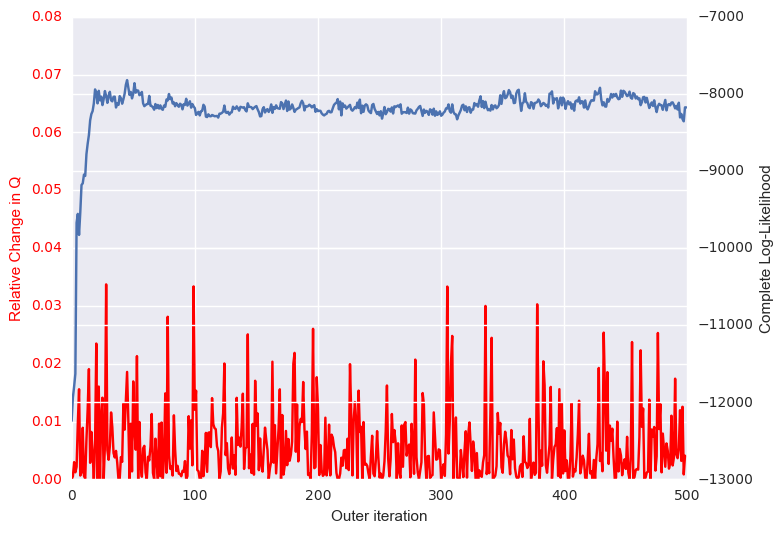

In [229]:
fig, ax1 = plt.subplots()
ax1.plot(relative_change_Q, 'r')
ax1.set_xlabel('Outer iteration')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Relative Change in Q', color='r')
ax1.tick_params('y', colors='r')
ax1.set_ylim([0,0.08])

ax2 = ax1.twinx()
ax2.plot(logpTotal)
ax2.set_ylabel('Complete Log-Likelihood')
ax2.tick_params('y')

fig.tight_layout()
plt.show()

[]

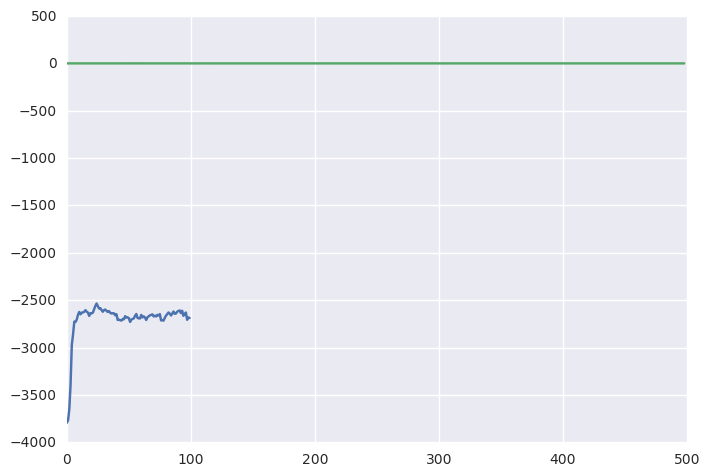

In [204]:
plt.plot(logpTotal)
plt.plot(relative_change_Q)
plt.plot()

In [167]:
O

array([[ 0,  1,  2, ..., -1, -1, -1],
       [ 3,  4,  1, ..., -1, -1, -1],
       [ 1,  2, -1, ..., -1, -1, -1],
       ..., 
       [12, -1, -1, ..., -1, -1, -1],
       [ 3,  5,  9, ..., -1, -1, -1],
       [ 3, 10,  9, ..., -1, -1, -1]])